In [1]:
import cv2
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from thinning import zhangSuen
from skimage.filters import threshold_otsu

In [2]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [3]:
def thin(img):
#     img[img < 129] = 0
    img = np.invert(img)
    
    Otsu_Threshold = threshold_otsu(img)   
    thresholded = img < Otsu_Threshold    # must set object region as 1, background region as 0 !

    return zhangSuen(thresholded)

In [4]:
def breakLines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ## (2) threshold
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    pts = cv2.findNonZero(threshed)
    ret = cv2.minAreaRect(pts)

    ## (3) minAreaRect on the nozeros
    H,W = img.shape[:2]
    (cx,cy), (w,h), ang = ret
    
    if (H > W and w > h) or (H < W and w < h):
        w,h = h,w
        ang += 90

    # ## (4) Find rotated matrix, do rotation
    M = cv2.getRotationMatrix2D((cx,cy), ang, 1.0)
    rotated = cv2.warpAffine(threshed, M, (img.shape[1], img.shape[0]))
    
    ## (5) find and draw the upper and lower boundary of each lines
    hist = cv2.reduce(rotated,1, cv2.REDUCE_AVG).reshape(-1)

    th = 2
    uppers = [y for y in range(H-1) if hist[y]<=th and hist[y+1]>th]
    lowers = [y for y in range(H-1) if hist[y]>th and hist[y+1]<=th]
    
    uppers_mod = [uppers[0]]
    lowers_mod = [lowers[0]]
    
    for i in range(1, len(uppers)):
        if (lowers[i] - lowers[i-1]) > 10:
            uppers_mod.append(uppers[i])
            lowers_mod.append(lowers[i])

    lines = []
    if len(uppers_mod) == len(lowers_mod):
        for i in range(len(uppers_mod)):
            lines.append(rotated[uppers_mod[i]-5:lowers_mod[i]+5, :])

    return lines

In [5]:
def breakWords(line):
    H, W = line.shape
    hist = cv2.reduce(line, 0, cv2.REDUCE_AVG).reshape(-1)

    th = 2
    lefts = [x for x in range(W-1) if hist[x] <= th and hist[x+1] > th]
    rights = [x for x in range(W-1) if hist[x] > th and hist[x+1] <= th]

    words = []
    if len(lefts) == len(rights):
        for i in range(len(rights)):
            words.append(line[:, lefts[i]:rights[i]])

    return words

In [6]:
## (1) read
img1 = cv2.imread("./DataSets/test1.png")
lines = breakLines(img1)

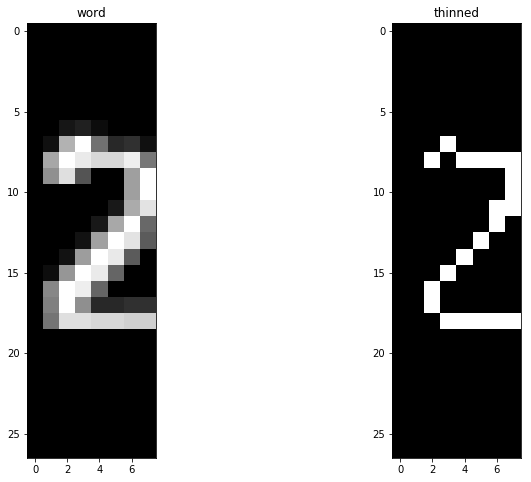

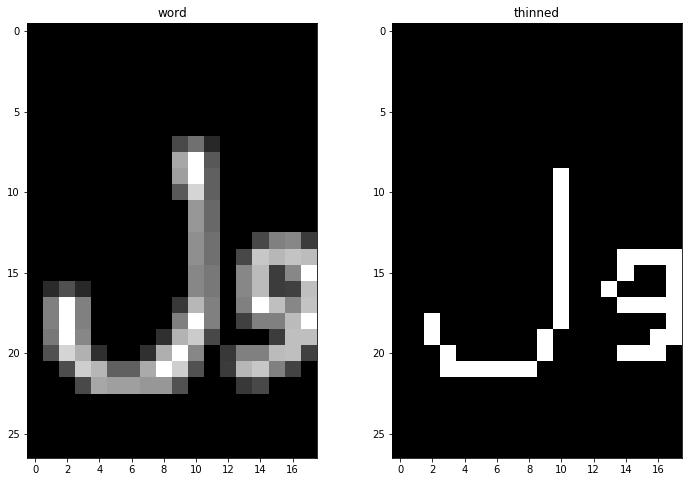

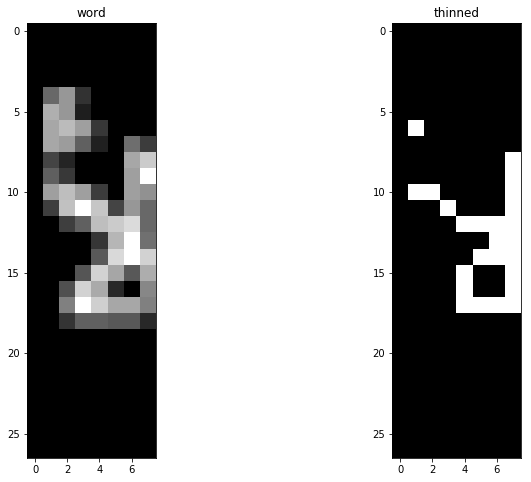

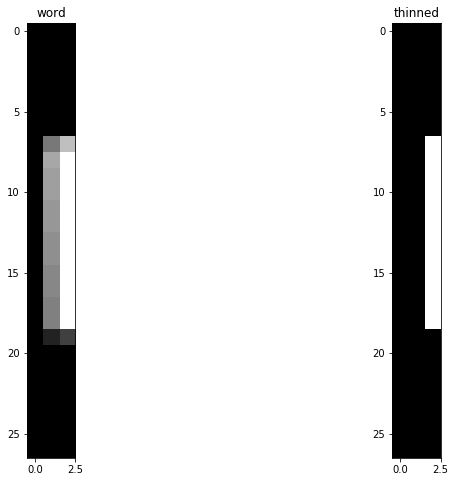

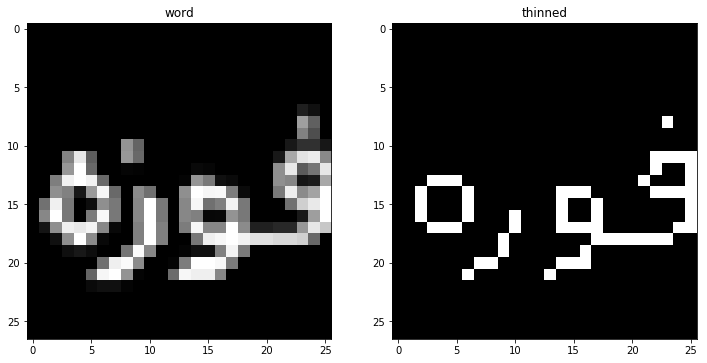

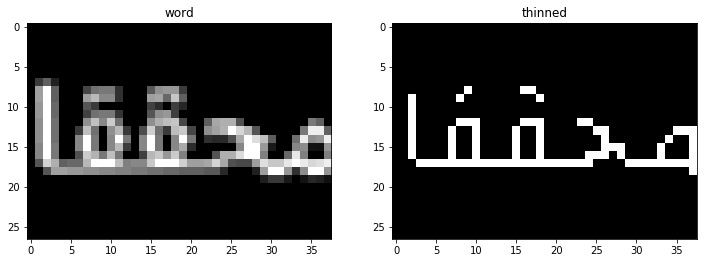

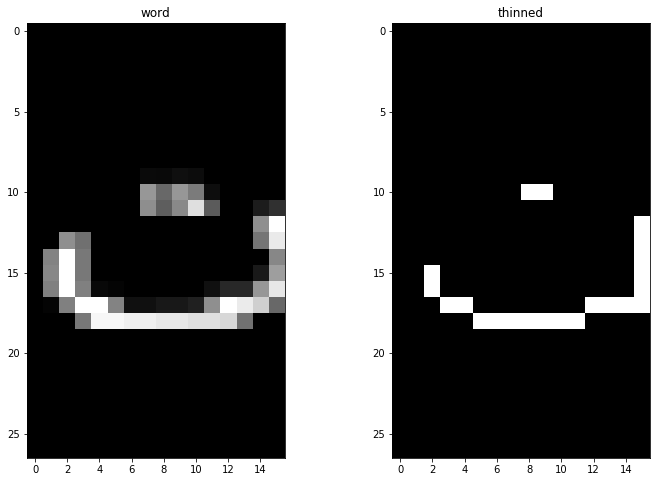

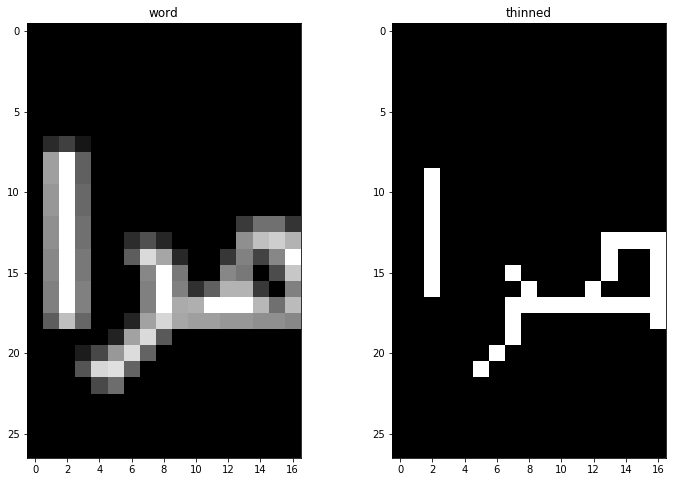

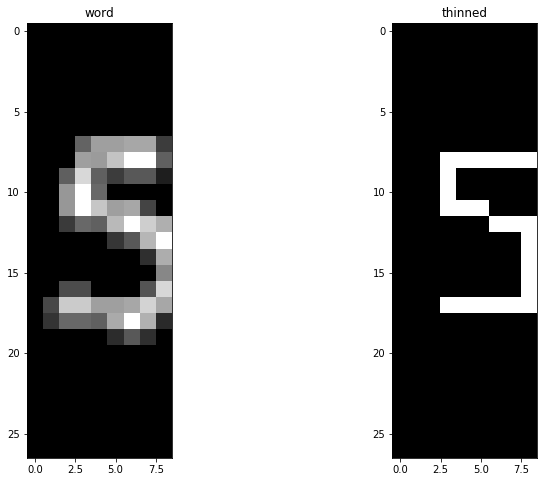

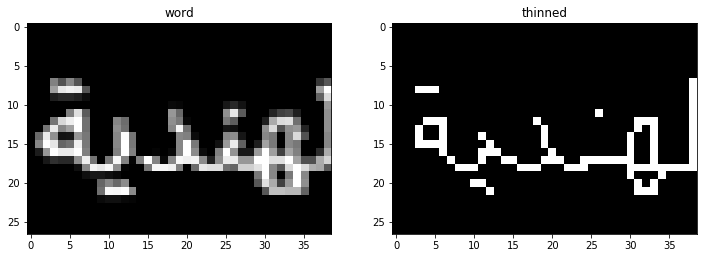

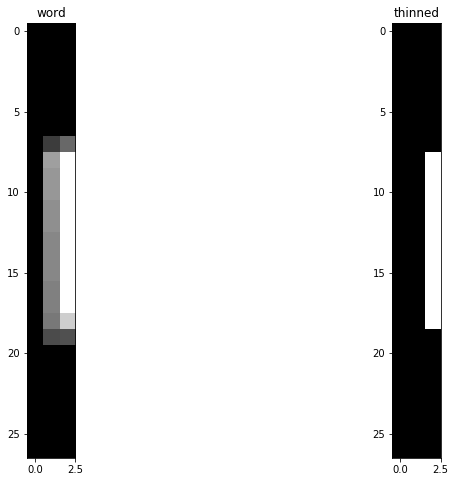

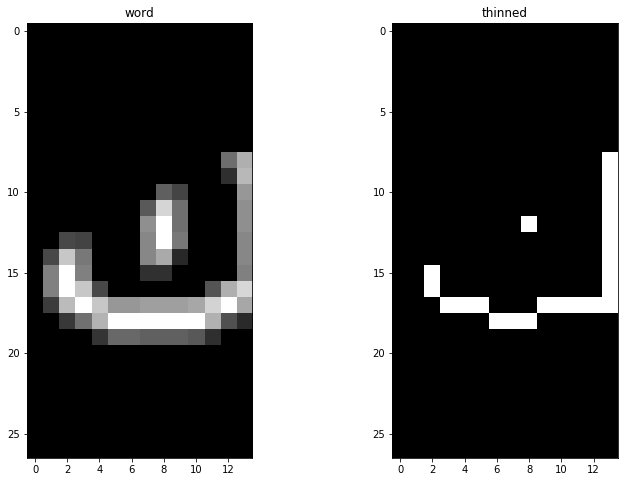

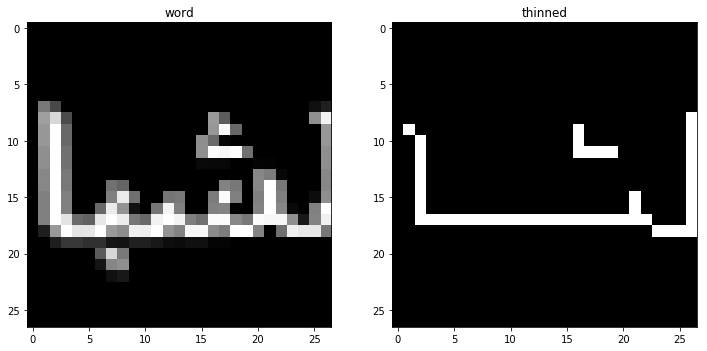

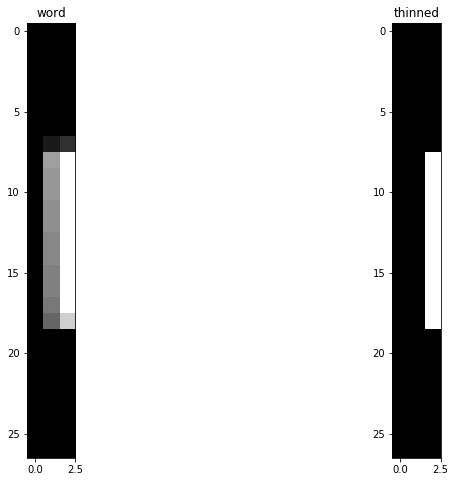

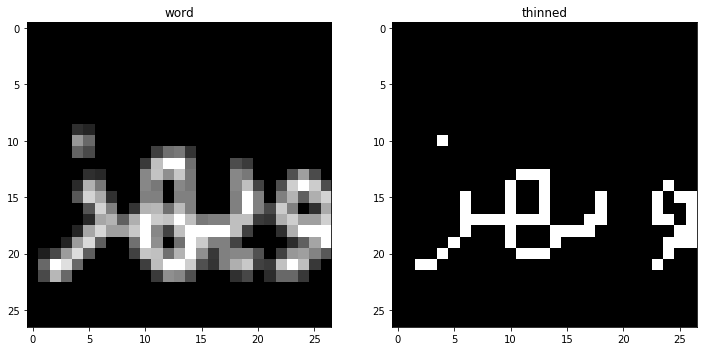

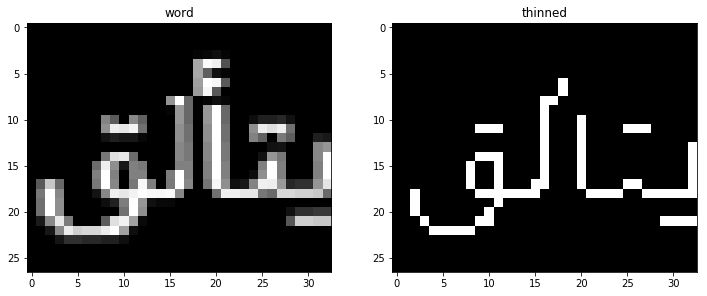

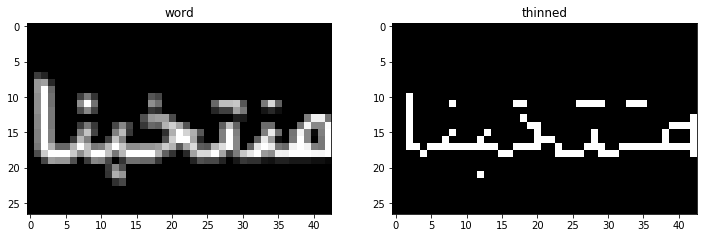

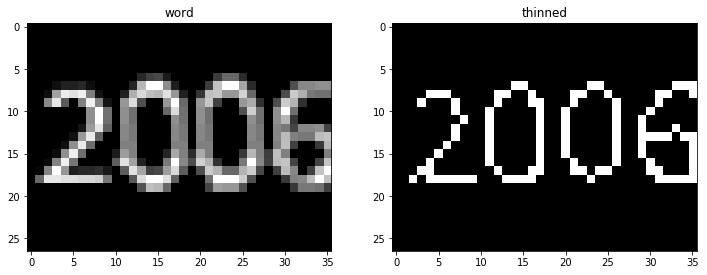

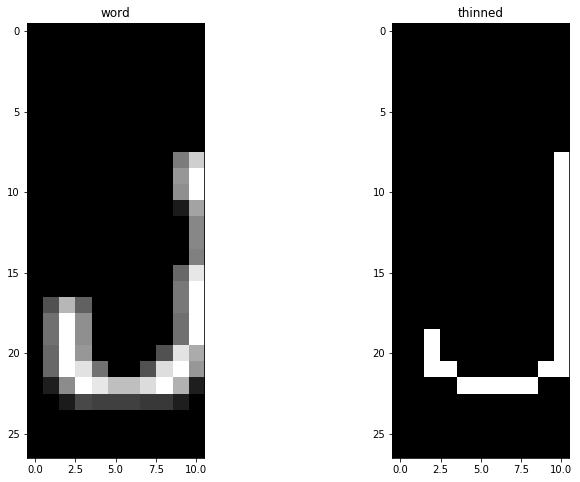

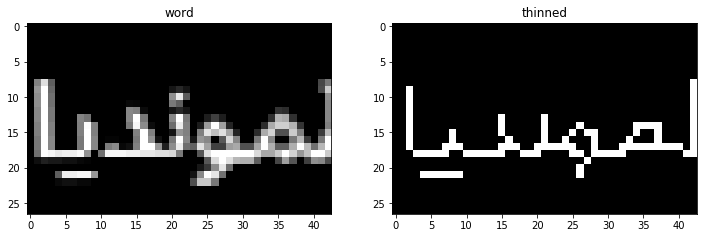

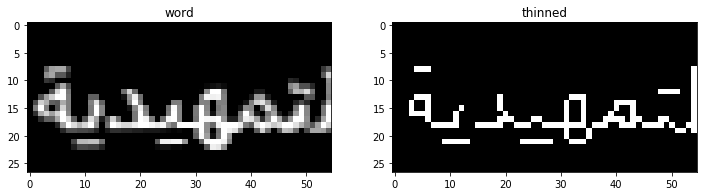

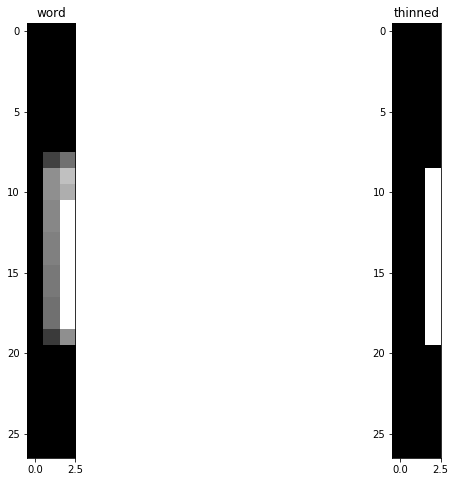

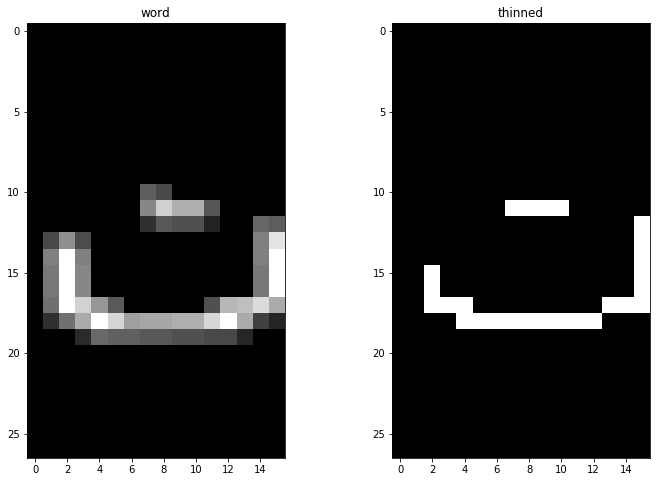

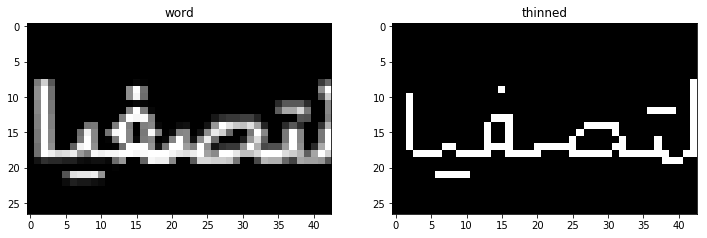

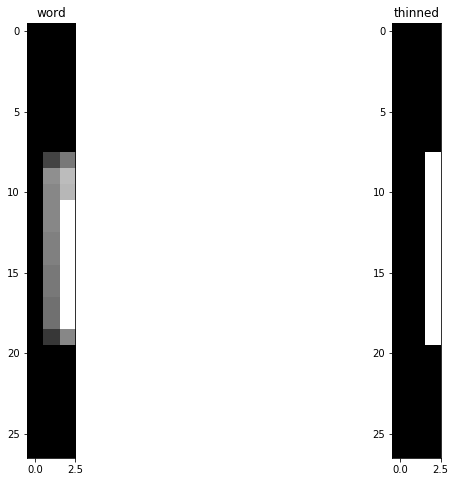

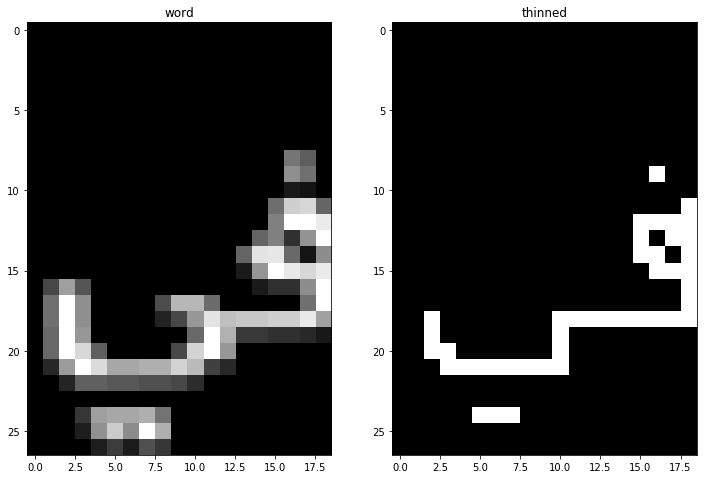

In [7]:
words = breakWords(lines[0])

for word in words:
    thinned = thin(word.copy())
    show_images([word, thinned], ["word", "thinned"])

In [8]:
# count = 1
#     cv2.imwrite("word" + str(count) + ".png", word)
#     count += 1